In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np
import scipy.optimize as sco
import scipy.interpolate as sci
import math

In [6]:
df = pd.read_csv("Price_Interval.csv")
# Extract 'Date' and 'Interval Range' columns
df_extracted = df[['Date', 'Interval_Range']]
df_extracted.head()

,Date,Interval_Range
0,2013-07-01,14.329286-14.723929
1,2013-07-02,14.623929-15.058214
2,2013-07-03,14.908929-15.106429
3,2013-07-05,14.833929-15.1175
4,2013-07-08,14.666071-15.035714


In [7]:
df_extracted[['Low', 'High']] = df_extracted['Interval_Range'].str.split('-', expand=True)

# Convert 'Low' and 'High' to numeric, and calculate the 'Mid' from 'Low' and 'High'.
df_extracted['Low'] = pd.to_numeric(df_extracted['Low'])
df_extracted['High'] = pd.to_numeric(df_extracted['High'])
df_extracted['Mid'] = (df_extracted['Low'] + df_extracted['High']) / 2

df_extracted = df_extracted.drop(columns=['Interval_Range'])
df_extracted.head()

C:\Users\eq220\AppData\Local\Temp\ipykernel_20824\2003912284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extracted[['Low', 'High']] = df_extracted['Interval_Range'].str.split('-', expand=True)
C:\Users\eq220\AppData\Local\Temp\ipykernel_20824\2003912284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extracted[['Low', 'High']] = df_extracted['Interval_Range'].str.split('-', expand=True)
C:\Users\eq220\AppData\Local\Temp\ipykernel_20824\2003912284.py:4: SettingWithCopyWarning: 
A value is t

,Date,Low,High,Mid
0,2013-07-01,14.329286,14.723929,14.526608
1,2013-07-02,14.623929,15.058214,14.841071
2,2013-07-03,14.908929,15.106429,15.007679
3,2013-07-05,14.833929,15.117500,14.975714
4,2013-07-08,14.666071,15.035714,14.850893


In [8]:
print(df_extracted.dtypes)

Date     object
Low     float64
High    float64
Mid     float64
dtype: object


# Determine p,d,q value

### ADF test

The ADF test uses an autoregressive model and optimizes an information criterion across multiple different lag values. The p-value resulting from the ADF test is used to reject or accept the null hypothesis.

If the p-value is less than the significance level (typically 0.05), we reject the null hypothesis and infer that the time series is indeed stationary.
If the p-value is greater than the significance level, we fail to reject the null hypothesis and infer that the time series is not stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

# Iterate over the columns of df_extracted, starting from the second column
for column_name in df_extracted.columns[1:]:
    print(f"Performing ADF test for: {column_name} price")
    adf_result = adfuller(df_extracted[column_name])
    print(f"ADF Statistic for {column_name}: {adf_result[0]} price")
    print(f"p-value for {column_name}: {adf_result[1]}")
    print()

Performing ADF test for: Low price
ADF Statistic for Low: 0.8268084445094904 price
p-value for Low: 0.9920568110147365

Performing ADF test for: High price
ADF Statistic for High: 0.8437930330753503 price
p-value for High: 0.9923111710264001

Performing ADF test for: Mid price
ADF Statistic for Mid: 0.8397720440263682 price
p-value for Mid: 0.9922517801428793



From the results of the Augmented Dickey-Fuller test, the ADF statistics are 0.83 and 0.84, and the P-value is 0.99, which is much larger than 0.05. As a result, we cannot refute the null hypothesis, which suggests that the time series corresponding to these prices exhibit non-stationarity.

### Autocorrelation Function (ACF)

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


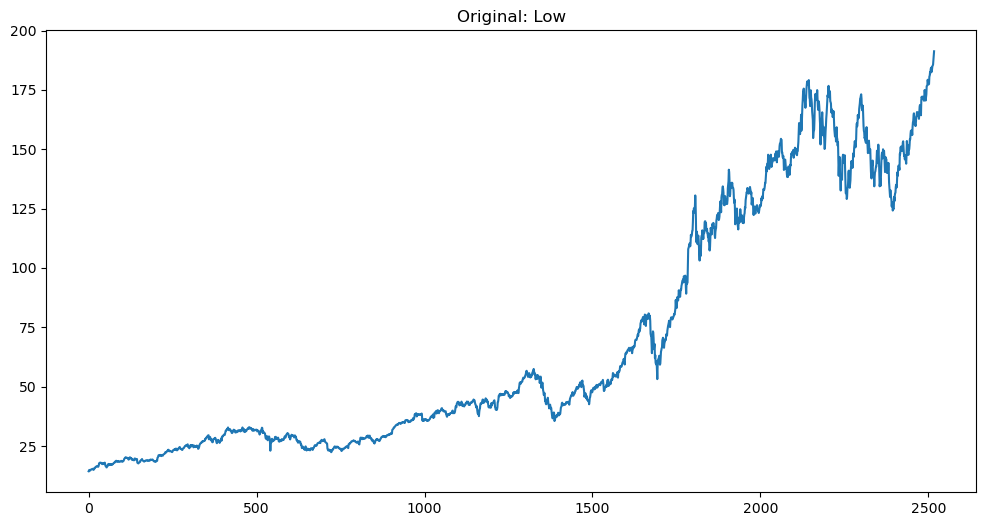

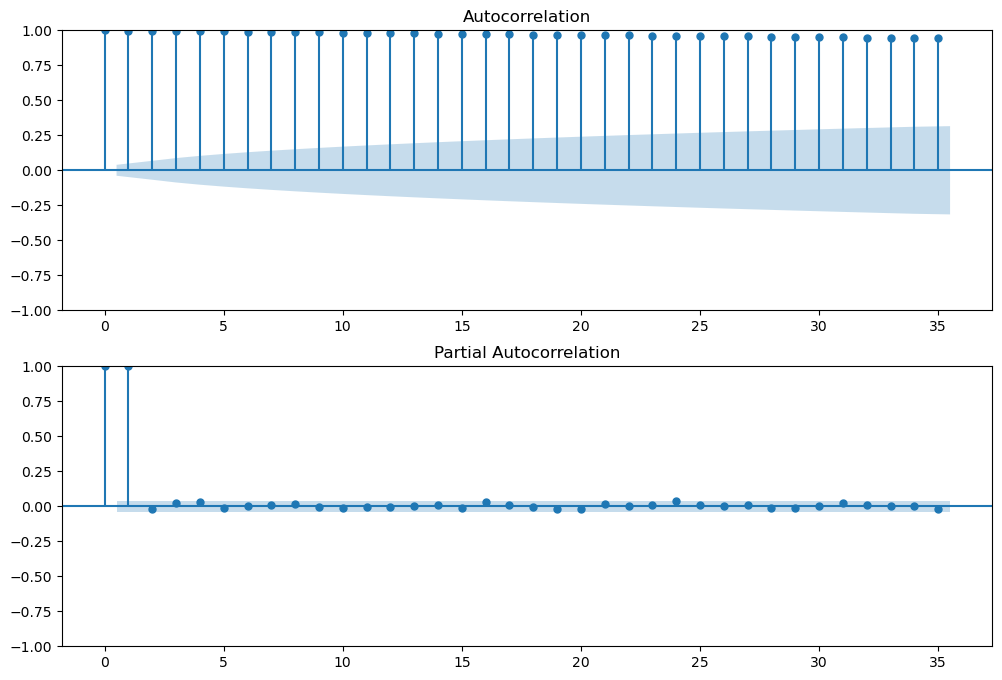

In [10]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['Low'].dropna())
ax1.set_title(f"Original: Low")

# Extract the 'Low' column and convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
low_price = df['Low']

# Plot the data
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(low_price, ax=ax[0])
ax[1] = plot_pacf(low_price, ax=ax[1])
plt.show()

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


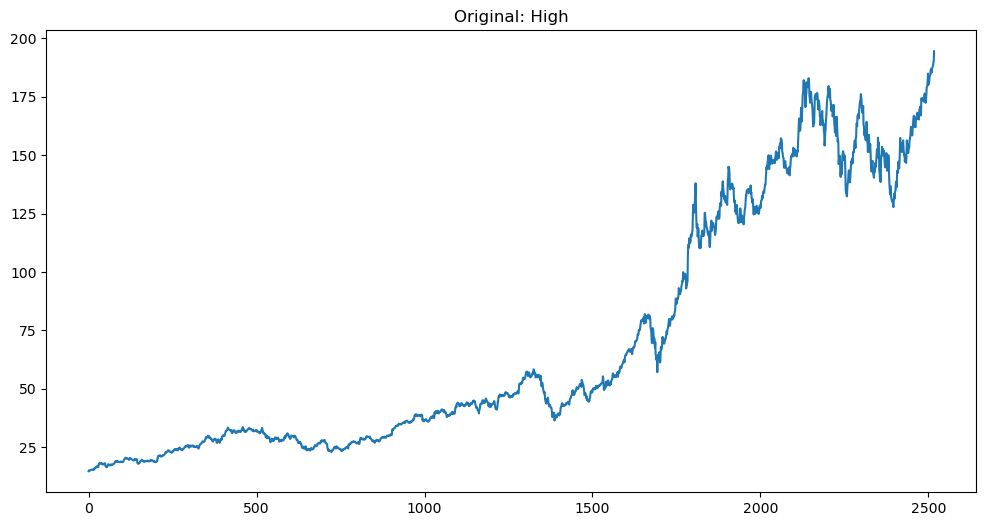

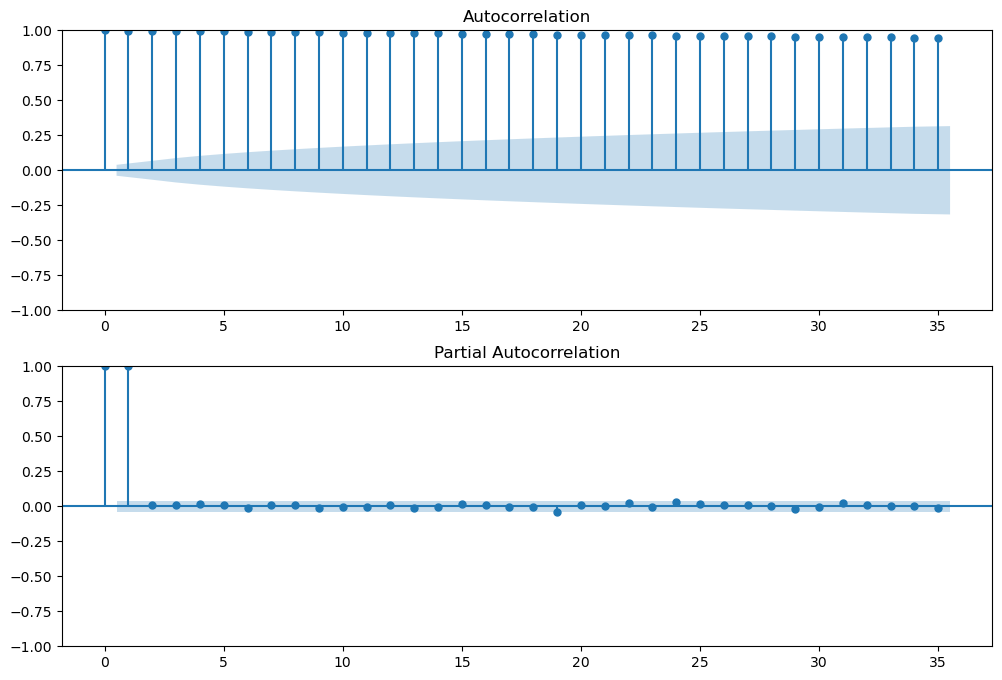

In [11]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['High'].dropna())
ax1.set_title(f"Original: High")

# Extract the 'High' column and convert the 'Date' column to datetime
df = pd.read_csv("Price_Interval.csv")
df['Date'] = pd.to_datetime(df['Date'])
low_price = df['High']

# Plot the data
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(low_price, ax=ax[0])
ax[1] = plot_pacf(low_price, ax=ax[1])
plt.show()

At the same time, I can also see from the graphs of auto-correlation function (ACF) and partial auto-correlation function (PACF) that the auto-correlation and partial auto-correlation of data are gradually decaying, which is also a feature of non-stationary sequences.

Therefore, I need to make a first-order difference on the data to make it smooth before applying the ARIMA model.

### Selecting d

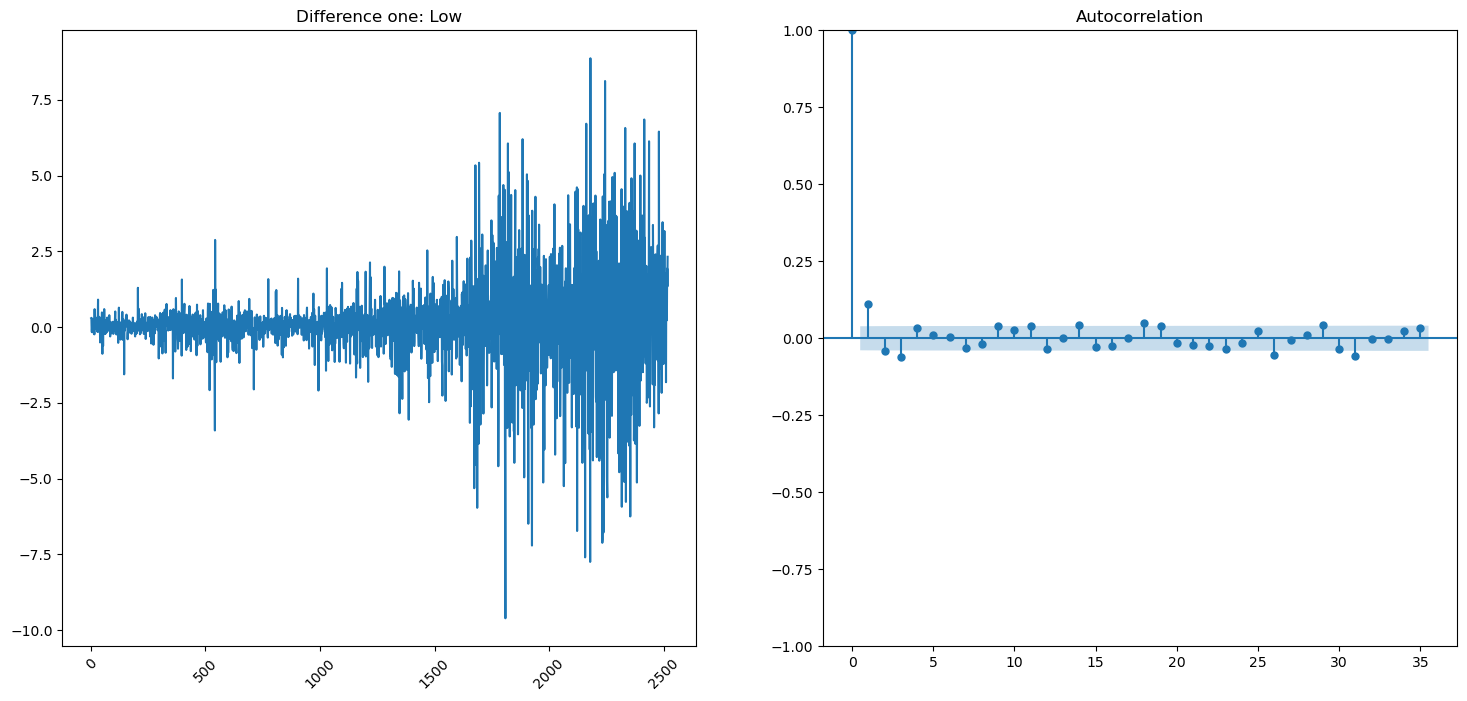

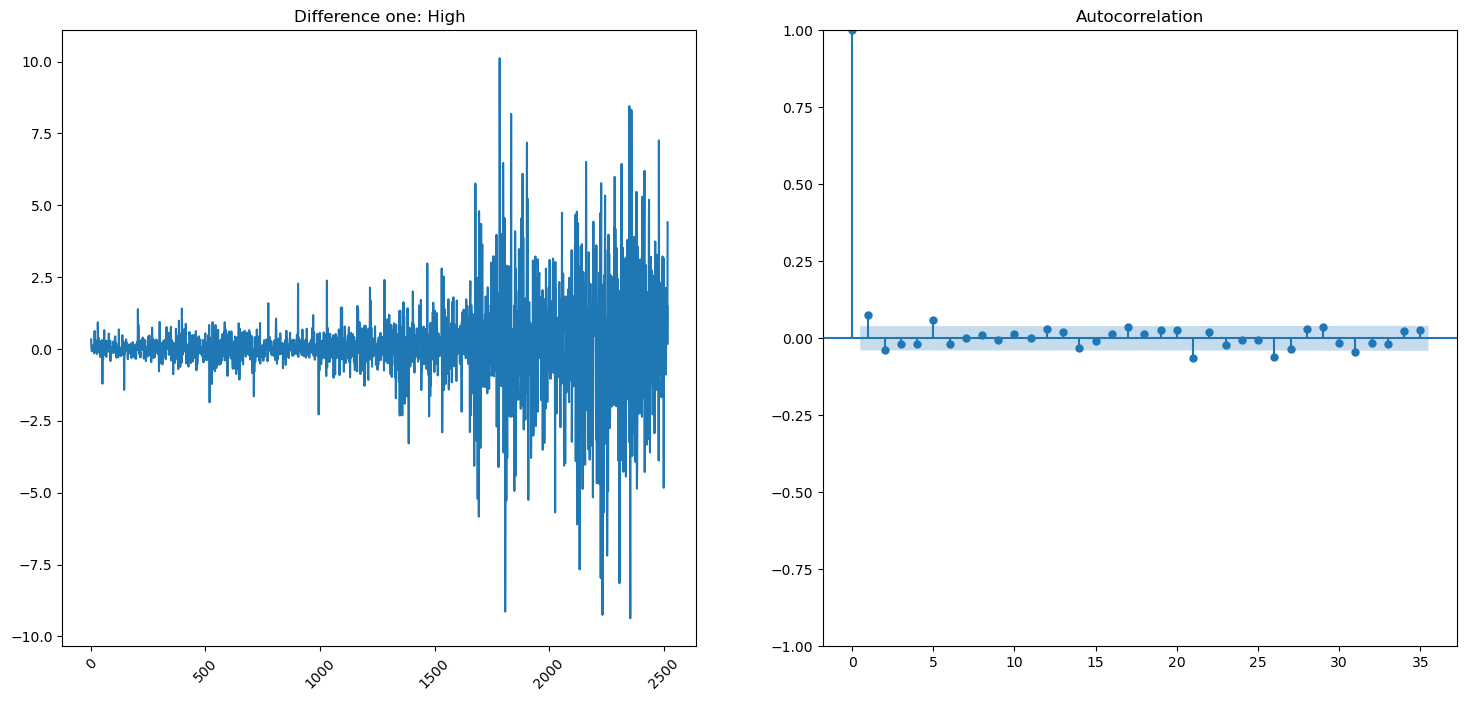

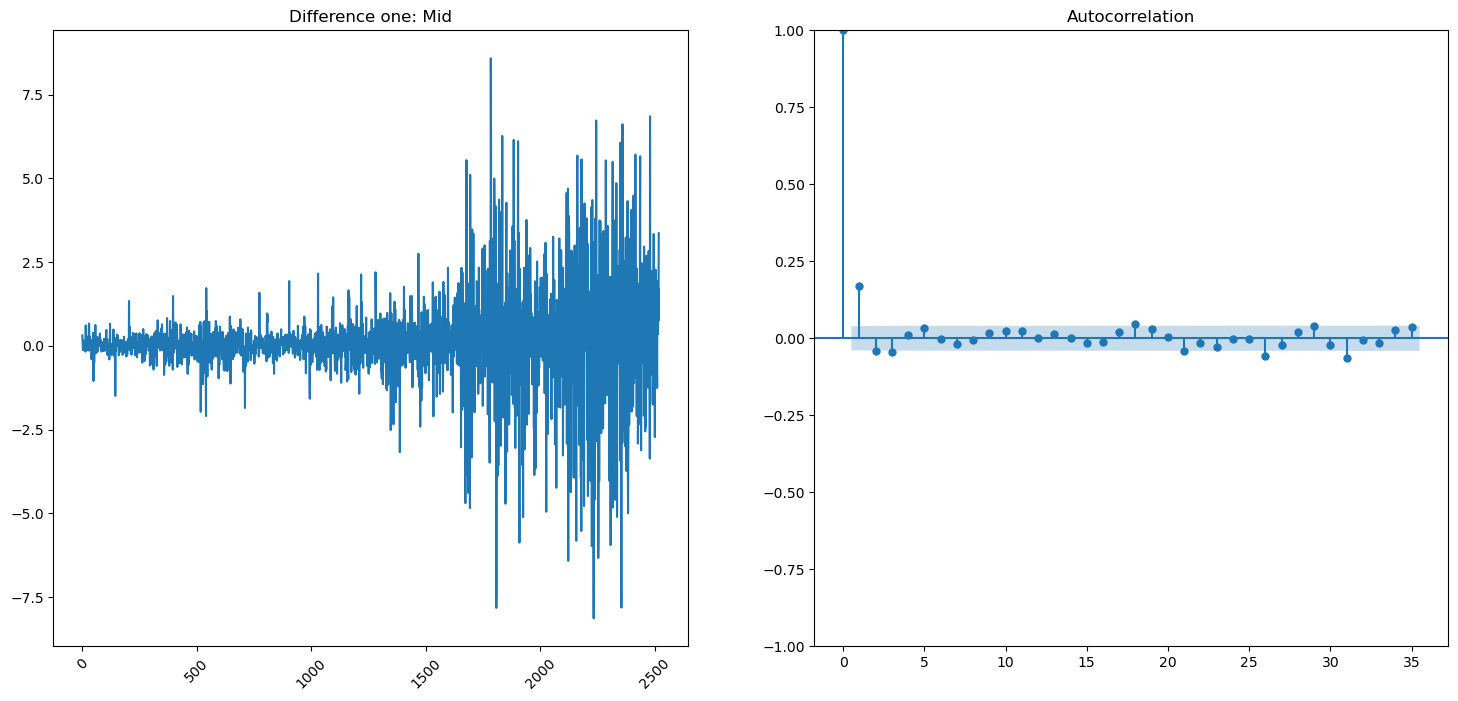

In [12]:
for price_name in df_extracted.columns[1:]:

    diff = df_extracted[price_name].diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(18,8))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
    axis1.set_title(f"Difference one: {price_name}")
    plot_acf(diff, ax=axis2)

In [13]:
# Perform first order differencing
data_diff = df_extracted['Low'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-10.194479961063925, 6.197979769201259e-18)

The ADF test result after first-order difference is as follows: the test statistic is -10.19, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [14]:
# Perform first order differencing
data_diff = df_extracted['High'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-20.304551986071097, 0.0)

The ADF test result after first-order difference is as follows: the test statistic is -20.30, and the p-value is 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [15]:
# Perform first order differencing
data_diff = df_extracted['Mid'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-34.70871685890082, 0.0)

The ADF test result after first-order difference is as follows: the test statistic is -34.71, and the p-value is 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

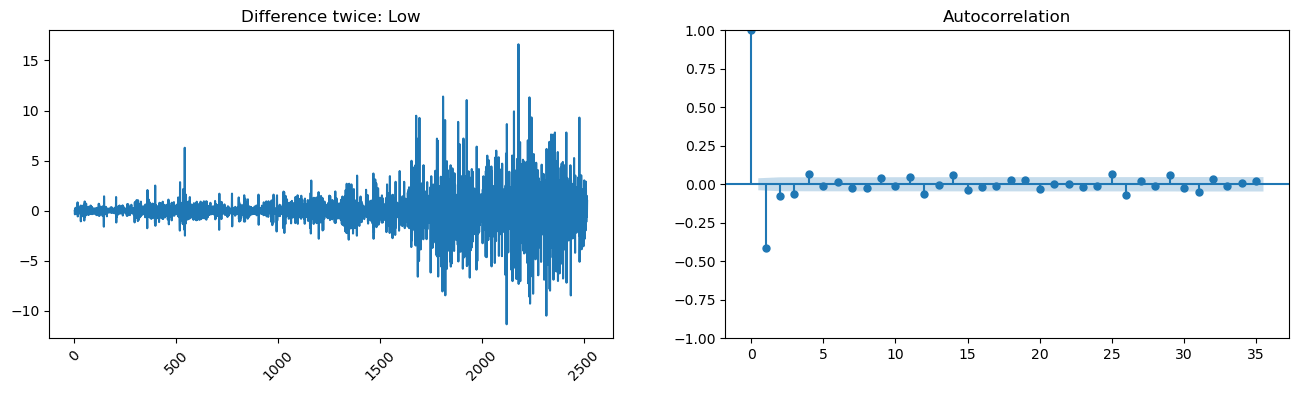

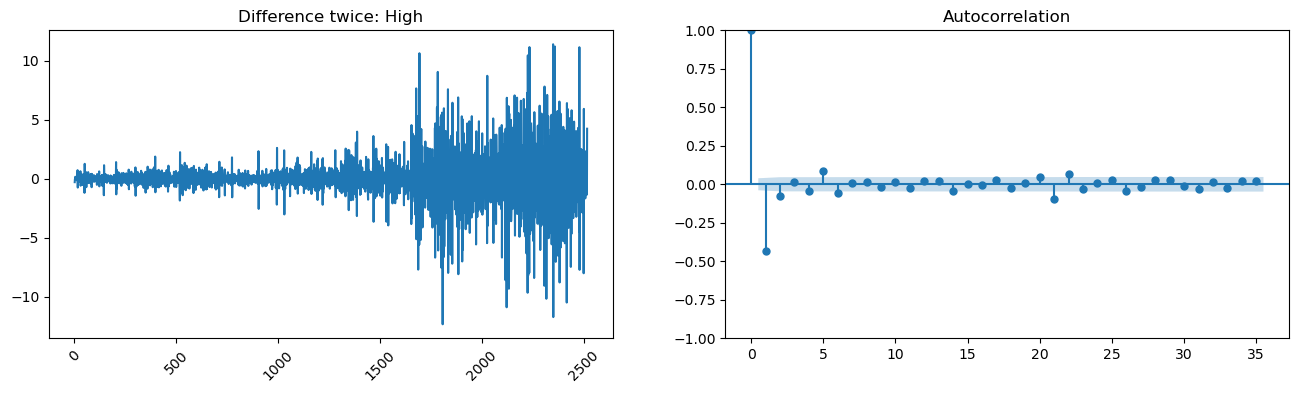

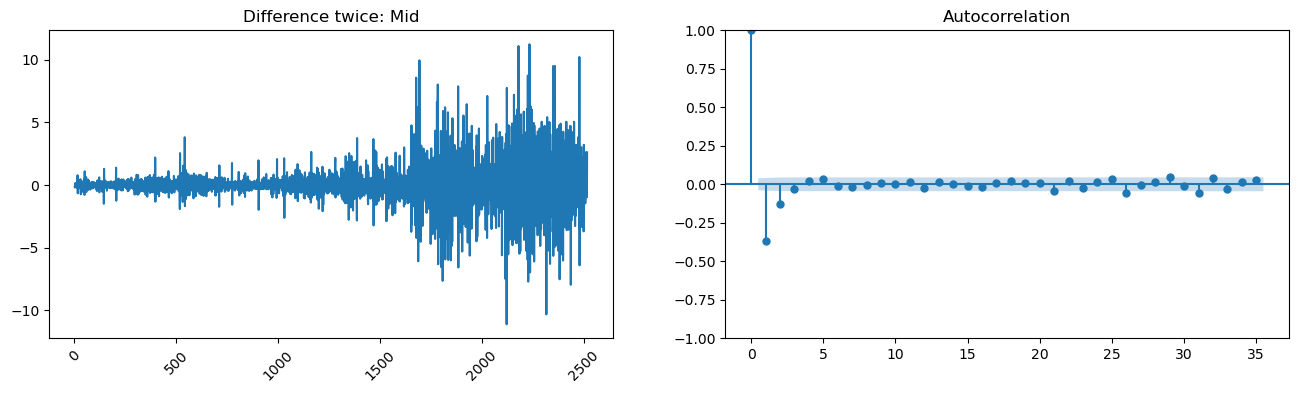

In [16]:
for price_name in df_extracted.columns[1:]:

    diff = df_extracted[price_name].diff().diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(16,4))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
    axis1.set_title(f"Difference twice: {price_name}")
    plot_acf(diff, ax=axis2);

The auto-correlation observed in both "Difference one" and "Difference twice" shows minimal variance. Therefore, for all price, we should set the differencing value to 1.

The pmdarima package can also be utilized to determine the degree of differencing. The following code show an example:

In [17]:
from pmdarima.arima.utils import ndiffs
n1 = ndiffs(df_extracted.Low, test="adf")
n2 = ndiffs(df_extracted.High, test="adf")
n3 = ndiffs(df_extracted.Mid, test="adf")

print(f"The best differencing value for Low price is:", n1)
print(f"The best differencing value for High price is:", n2)
print(f"The best differencing value for Mid price is:", n3)

The best differencing value for Low price is: 1
The best differencing value for High price is: 1
The best differencing value for Mid price is: 1


As a result, I set d=1 for Low price, high price and Mid price.

### Selecting p

p is the order of the Auto Regressive (AR) term. It corresponds to the number of lags to be used as predictors. The necessary count of AR components can be ascertained by examining the Partial Auto-correlation (PACF) plot. Partial auto-correlation signifies the correlation between the time series and its lags.

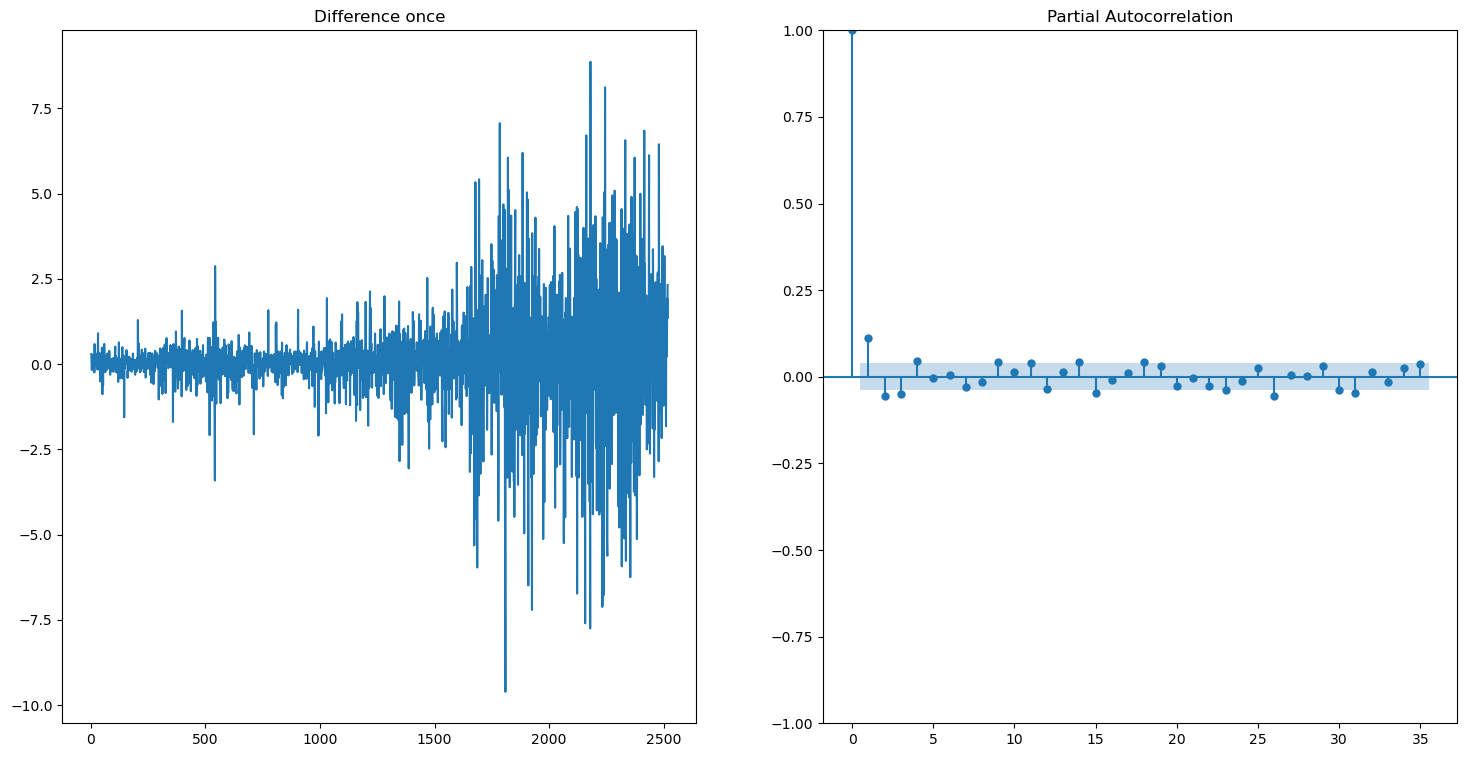

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Low prices
first_diff = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

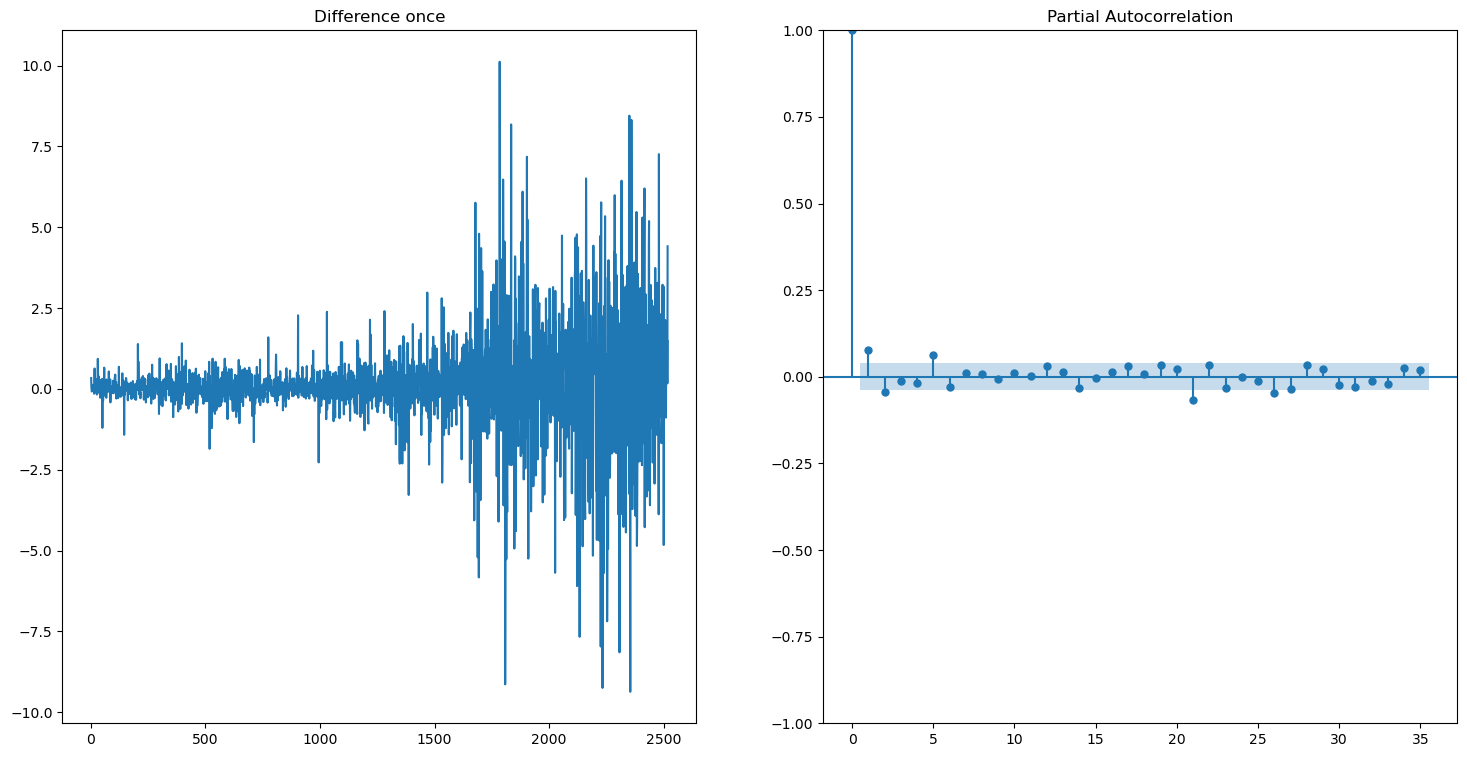

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the High prices
first_diff = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

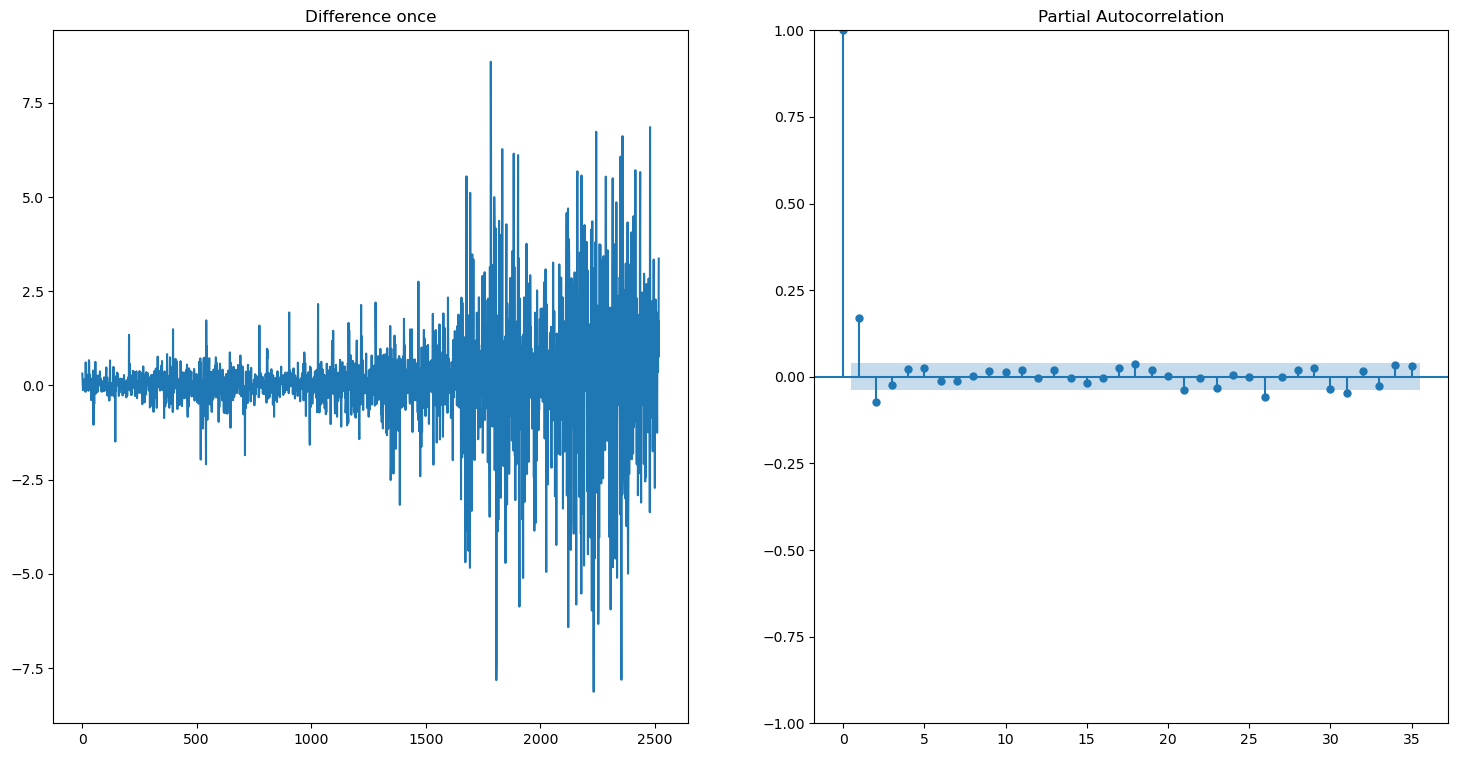

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Mid prices
first_diff = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

From the PACF plot above, it looks like the PACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering p=1 for three ARIMA models.

### Selecting q

'q' is the order of the Moving Average (MA) term. It signifies the number of lagged forecast errors that should be incorporated into the ARIMA model. The number of MA terms can be determined by inspecting the Auto-correlation Function (ACF) plot.

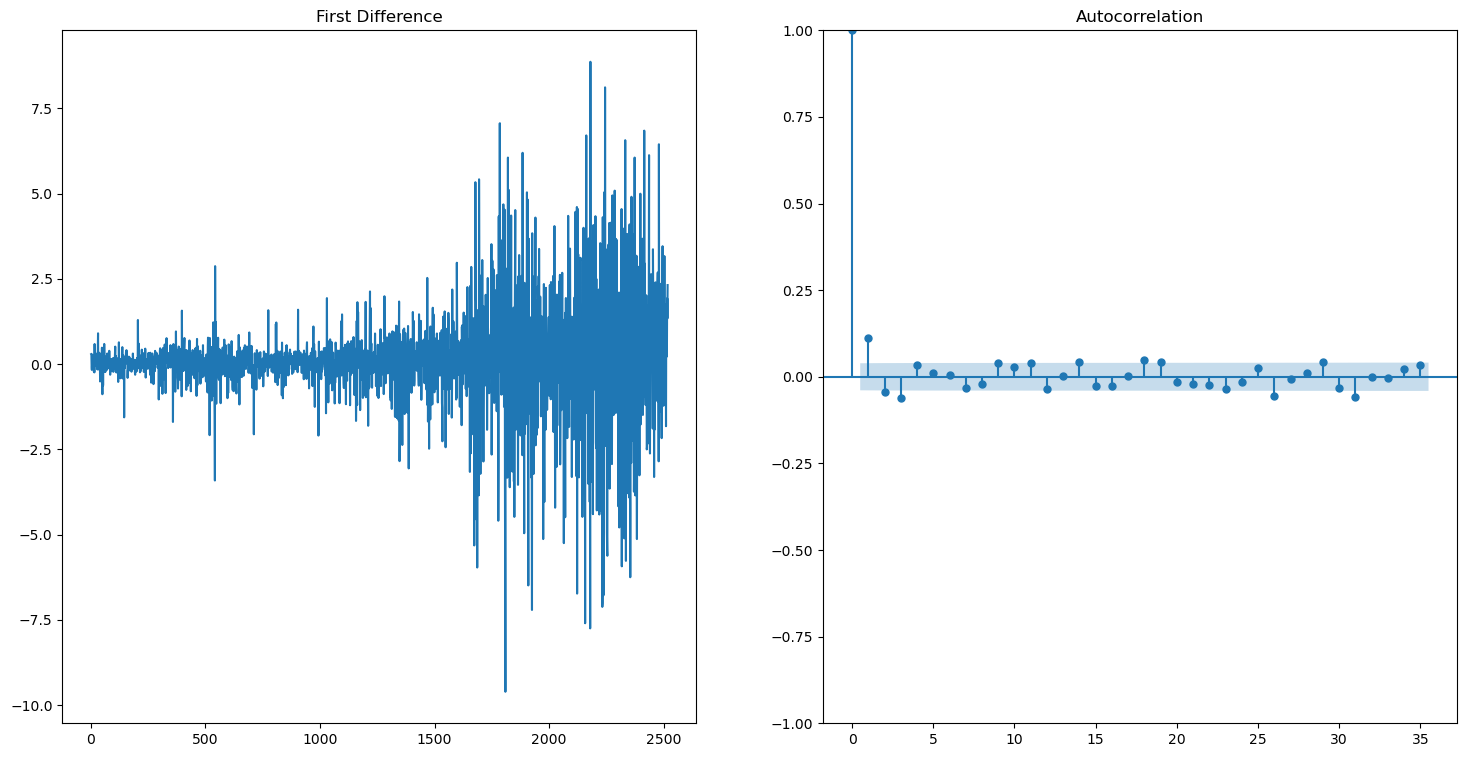

In [21]:
# Calculate the first differences of the 'Low' column
diff_low = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

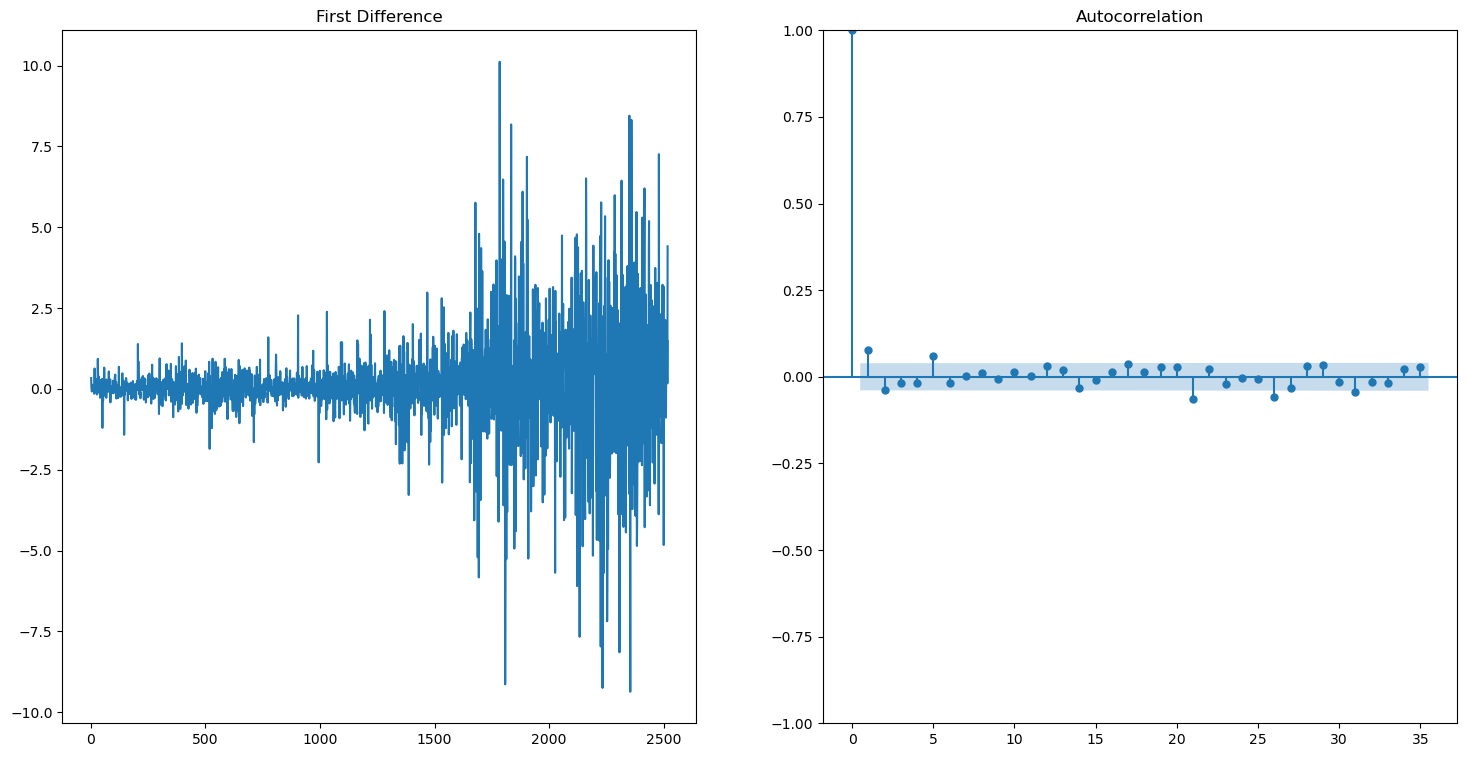

In [22]:
# Calculate the first differences of the 'High' column
diff_low = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

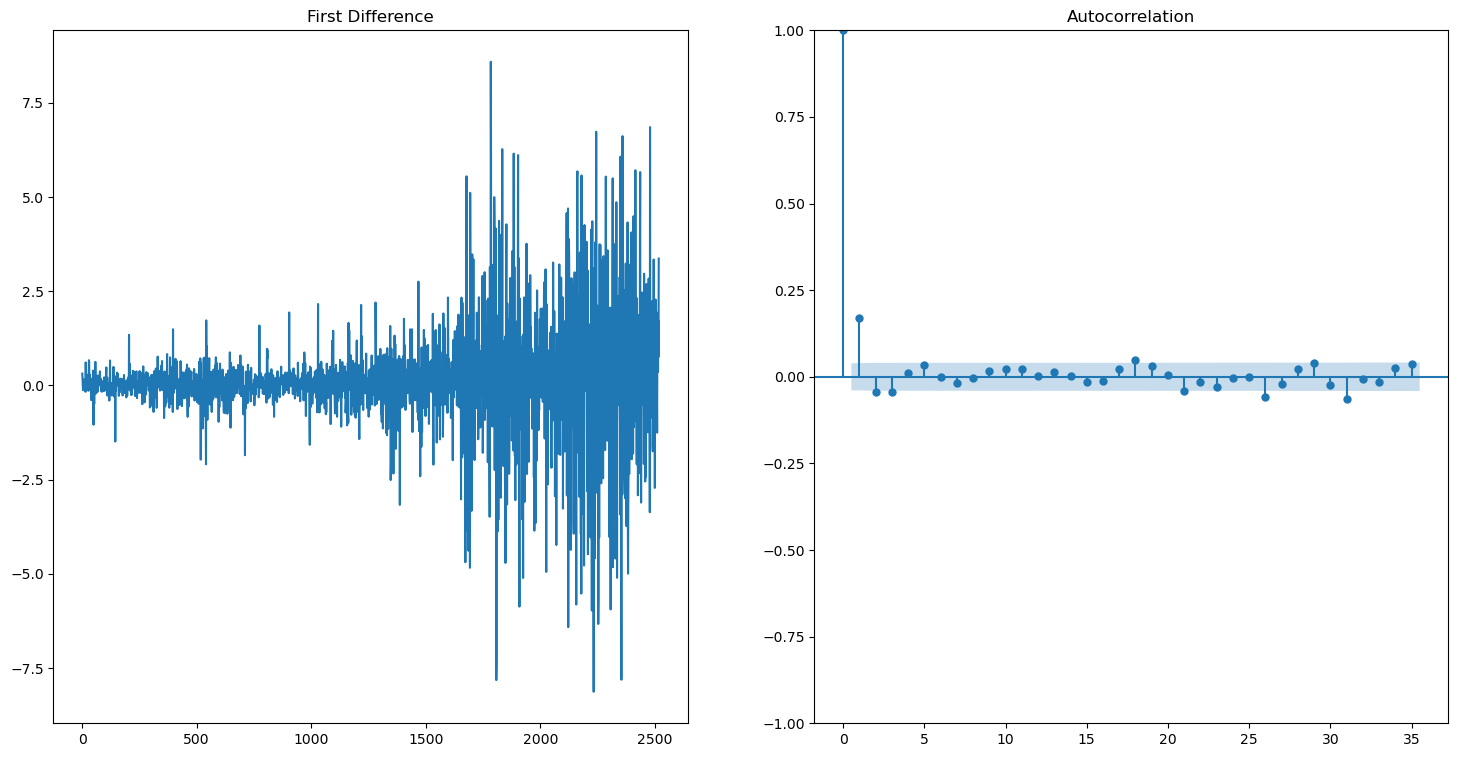

In [23]:
# Calculate the first differences of the 'Mid' column
diff_low = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

Looking at the ACF plot, I typically consider the point where the ACF plot crosses the upper confidence interval for the first time as the q value for the ARIMA model. It is the lag after which the correlation is no longer significant.

From the ACF plot above, it looks like the ACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering q=1 for my ARIMA model.

In [24]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Low'], order=[1,1,1])
model_Low_price_fit = model.fit()
model_Low_price_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4525.916
Date:                Tue, 01 Aug 2023   AIC                           9057.832
Time:                        17:16:40   BIC                           9075.324
Sample:                             0   HQIC                          9064.180
                               - 2518                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0906      0.098     -0.929      0.353      -0.282       0.101
ma.L1          0.2100      0.098      2.149      0.032       0.018       0.401
sigma2         2.1348      0.029     73.531      0.000       2.078       2.192
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4646.48
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              35.79   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['High'], order=[1,1,1])
model_Low_price_fit = model.fit()
model_Low_price_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4505.588
Date:                Tue, 01 Aug 2023   AIC                           9017.175
Time:                        17:16:41   BIC                           9034.668
Sample:                             0   HQIC                          9023.524
                               - 2518                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6002      0.077     -7.824      0.000      -0.751      -0.450
ma.L1          0.6749      0.071      9.556      0.000       0.536       0.813
sigma2         2.1006      0.026     80.701      0.000       2.050       2.152
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              7463.79
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              53.77   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Mid'], order=[1,1,1])
model_Low_price_fit = model.fit()
model_Low_price_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Mid   No. Observations:                 2518
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4319.004
Date:                Tue, 01 Aug 2023   AIC                           8644.008
Time:                        17:16:42   BIC                           8661.501
Sample:                             0   HQIC                          8650.357
                               - 2518                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0919      0.066     -1.391      0.164      -0.221       0.038
ma.L1          0.2777      0.065      4.292      0.000       0.151       0.405
sigma2         1.8111      0.025     73.628      0.000       1.763       1.859
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4672.68
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              43.42   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot residual errors

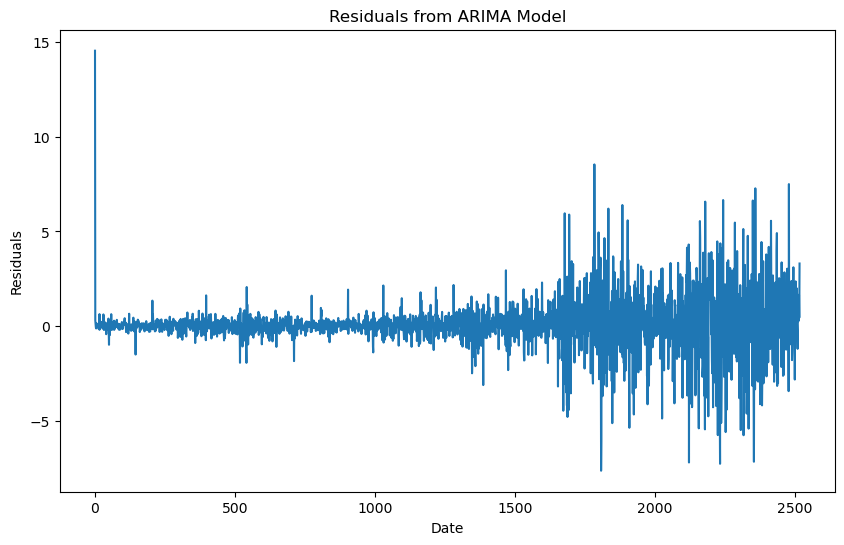

In [27]:
residuals = model_Low_price_fit.resid

# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

This is the residual plot from the ARIMA model. As you can see from the graph, the residuals fluctuate roughly up and down around the 0 line, with no obvious pattern. This indicates that the model has captured the main information in the data, and there are no remaining trends or periodicity in the residuals. This is a characteristic of a good model.

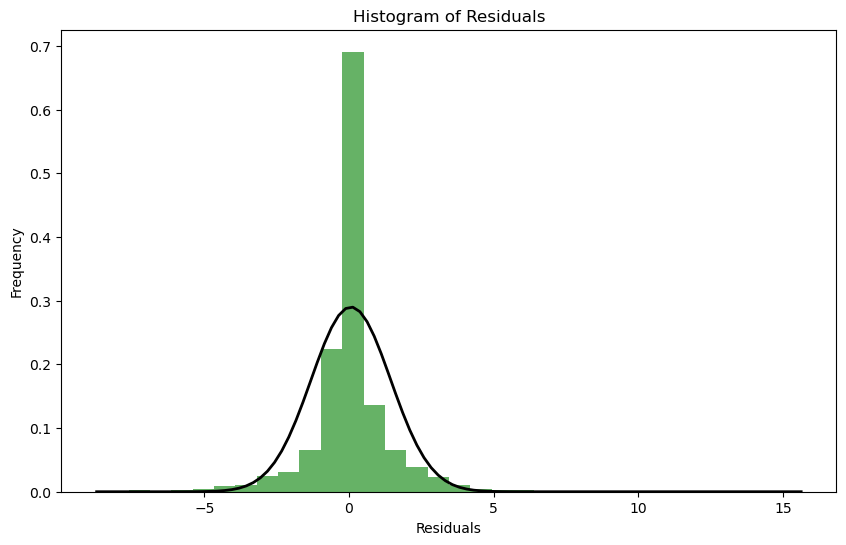

In [28]:
from scipy.stats import norm
# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

This is the histogram of the ARIMA model residuals, with the black line representing the probability density function of the normal distribution. As can be seen from the figure, the distribution of residuals is roughly symmetric and close to a normal distribution. This is a characteristic of a good model because, ideally, we want the model's residuals to be random and follow a normal distribution.

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting p

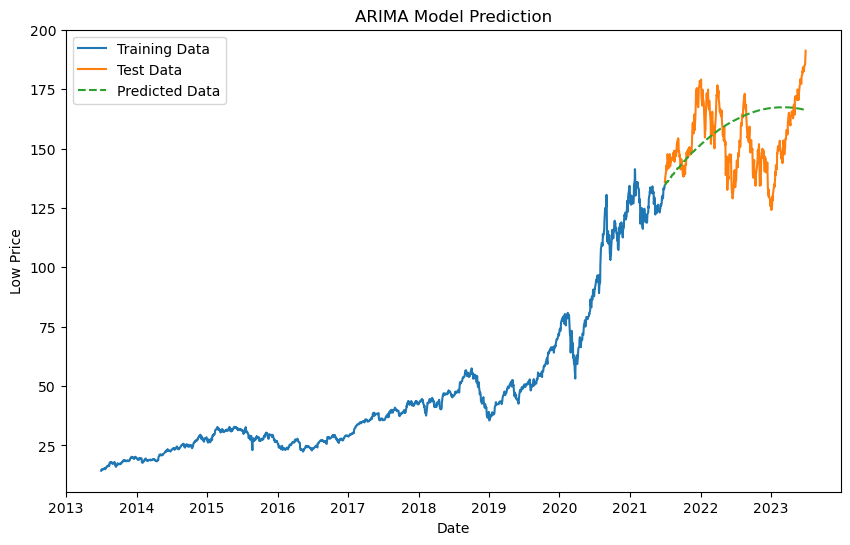

In [39]:
# Select the column we want to predict and set 'Date' as the index
data = pd.DataFrame(df_extracted[['Date', 'Low']])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

start_date = pd.to_datetime(test.index.min())
end_date = pd.to_datetime(test.index.max())

# Use the best parameters to train the model
model = ARIMA(train, order=(16,3,16))
model_fit = model.fit()
forecast = model_fit.forecast(len(test))
# forecast = model_fit.predict('20210630','20230630', dynamic = True, typ = 'levels')
forecast_series = pd.Series(forecast.values, index=test.index) # Updated this line

# Draw a line chart of forecast results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series, label='Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [30]:

qq= pd.to_datetime(end_date)
qq

Timestamp('2023-06-30 00:00:00')

In [31]:
forecast.head(20)

Date
2021-06-30    134.631389
2021-07-01    135.070388
2021-07-02    135.340300
2021-07-06    135.477586
2021-07-07    135.445610
2021-07-08    135.888046
2021-07-09    135.920484
2021-07-12    135.770445
2021-07-13    136.125498
2021-07-14    136.765127
2021-07-15    136.984501
2021-07-16    136.522428
2021-07-19    136.486389
2021-07-20    137.165169
2021-07-21    137.726730
2021-07-22    137.595441
2021-07-23    137.390046
2021-07-26    137.631911
2021-07-27    138.087565
2021-07-28    138.254543
Name: predicted_mean, dtype: float64

In [32]:
df_extracted.head()

,Date,Low,High,Mid
0,2013-07-01,14.329286,14.723929,14.526608
1,2013-07-02,14.623929,15.058214,14.841071
2,2013-07-03,14.908929,15.106429,15.007679
3,2013-07-05,14.833929,15.117500,14.975714
4,2013-07-08,14.666071,15.035714,14.850893


In [33]:
# data = pd.read_csv("AAPL.csv")
    # Split data for training

def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test

In [34]:
import pandas as pd
from pmdarima import auto_arima

# 这里假设数据在 'stock_data.csv' 文件中，我们将其读取为 DataFrame
# 由于你的数据是中文的，可能需要制定encoding为'utf-8'
# data = pd.read_csv('AAPL.csv', encoding='utf-8')
# data = df_extracted


# 将 'Date' 列转换为 datetime 类型，并设为索引
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

data = pd.DataFrame(df_extracted[['Date', 'Low']])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

train, test = train_test_split(data['Low'], 0.2)


# 使用 auto_arima 函数找到最优的 ARIMA 模型
# arima_model = auto_arima(train,
#                    start_p=0, start_q=0,
#                    max_p=3, max_q=3, m=12,
#                    start_P=0, seasonal=True,
#                    d=1, D=1, trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
#
# arima_model.summary()

arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                          max_p=3, max_d=5, max_q=3, start_P=0,
                          D=1, start_Q=0, max_P=3, max_D=5,
                          max_Q=3, m=5, seasonal=True,
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=7238.624, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=6635.425, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=7220.989, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=6479.617, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=6359.193, Time=0.63 sec
 ARIMA(1,1,0)(3,1,1)[5]             : AIC=inf, Time=2.75 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(3,1,0)[5]             : AIC=6371.001, Time=0.37 sec
 ARIMA(2,1,0)(3,1,0)[5]             : AIC=6347.169, Time=0.68 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=6468.507, Time=0.41 sec
 ARIMA(2,1,0)(3,1,1)[5]             : AIC=inf, Time=2.58 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=1.88 sec
 ARIMA(3,1,0)(3,1,0)[5]             : AIC=6347.074, Time=0.66 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=6467.405, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2014
Model:             SARIMAX(2, 1, 2)x(3, 1, [], 5)   Log Likelihood               -3156.797
Date:                            Tue, 01 Aug 2023   AIC                           6329.595
Time:                                    17:18:39   BIC                           6374.434
Sample:                                         0   HQIC                          6346.055
                                           - 2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9040      0.026    -34.522      0.000      -0.955      -0.853
ar.L2         -0.8125      0.022    -36.699      0.000      -0.856      -0.769
ma.L1          1.0017      0.024     41.102      0.000       0.954       1.049
ma.L2          0.8500      0.022     39.014      0.000       0.807       0.893
ar.S.L5       -0.6717      0.011    -60.389      0.000      -0.694      -0.650
ar.S.L10      -0.4404      0.014    -32.323      0.000      -0.467      -0.414
ar.S.L15      -0.2572      0.012    -20.995      0.000      -0.281      -0.233
sigma2         1.3562      0.018     77.173      0.000       1.322       1.391
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10801.33
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              16.94   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Date
2021-06-30    134.382312
2021-07-01    134.453114
2021-07-02    134.848047
2021-07-06    134.949010
2021-07-07    136.789129
                 ...    
2023-06-26    389.310500
2023-06-27    389.682605
2023-06-28    389.724807
2023-06-29    390.006018
2023-06-30    390.145578
Length: 504, dtype: float64


C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


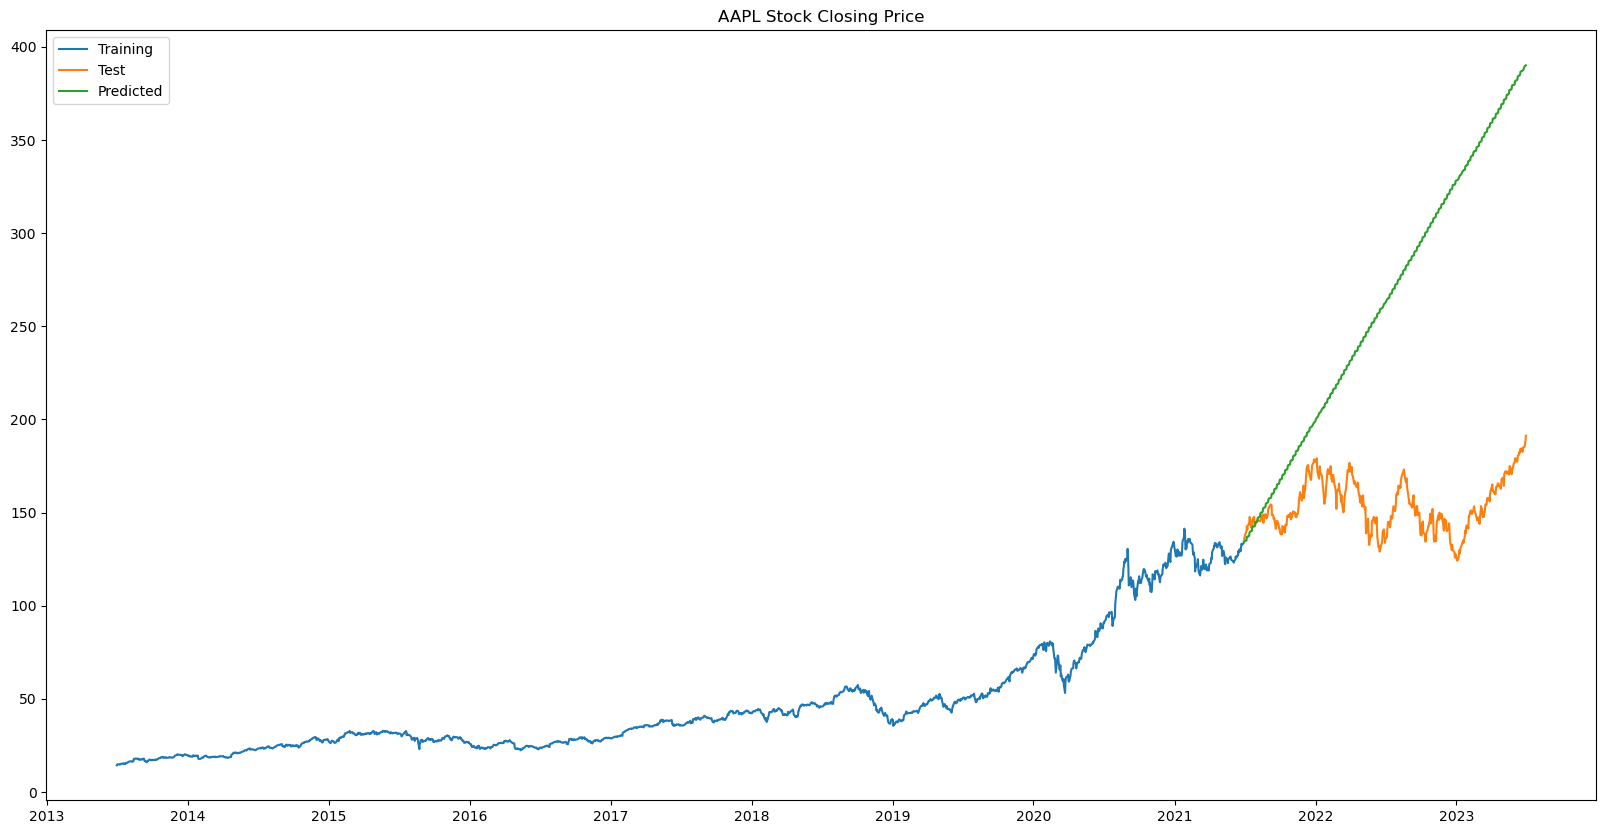

In [35]:
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted values
# prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
# prediction.columns = ['Close']
# forecast_result = model_fit.forecast(steps=len(test))
# # Create a new series with predictions
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# model_fit = arima_model.fit()
# forecast_result = model_fit.forecast(steps=len(test))
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# print(forecast_series)

# Use the model to make predictions
forecast_result = arima_model.predict(n_periods=len(test))

# Create a series with the predictions
forecast_series = pd.Series(forecast_result.values, index=test.index)

print(forecast_series)

# Plot the results
plt.figure(figsize=(20,10))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(forecast_series, label="Predicted")
plt.title("AAPL Stock Closing Price")
plt.legend(loc='best')
plt.show()
